Chapter 8
# 相关性股价模型
Book_6《数据有道》 | 鸢尾花书：从加减乘除到机器学习

In [1]:
# !pip install yfinance

In [2]:
# initializations and download results 
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

In [3]:
tickers = ['TSLA','TSM','COST','NVDA','META','AMZN','AAPL','NFLX','GOOGL'];
# stock_levels_df = web.get_data_yahoo(tickers, start = '2020-08-01', end = '2021-08-01')

from datetime import datetime
startdate = datetime(2020,8,1)
enddate = datetime(2021,8,1)
stock_levels_df = yf.download(tickers = tickers,
                  start = startdate,
                  end = enddate)

stock_levels_df.to_csv("9_stocks_level.csv")

[*********************100%%**********************]  9 of 9 completed


In [4]:
print(stock_levels_df.round(2).head())
print(stock_levels_df.round(2).tail())

#%% Plot lineplot of stock prices

           Adj Close                                                        \
                AAPL    AMZN    COST  GOOGL    META    NFLX    NVDA   TSLA   
Date                                                                         
2020-08-03    106.67  155.59  305.97  74.14  251.96  498.62  109.79  99.00   
2020-08-04    107.38  156.94  315.70  73.67  249.83  509.64  111.96  99.13   
2020-08-05    107.77  160.25  315.86  73.95  249.12  502.11  112.55  99.00   
2020-08-06    111.53  161.25  318.97  75.25  265.28  509.08  113.03  99.31   
2020-08-07    109.00  158.37  316.74  74.92  268.44  494.73  111.68  96.85   

                    Close  ...   Open     Volume                      \
              TSM    AAPL  ...    TSM       AAPL       AMZN     COST   
Date                       ...                                         
2020-08-03  73.92  108.94  ...  77.77  308151200  101494000  2480200   
2020-08-04  75.08  109.67  ...  79.33  173071600   93886000  3933300   
2020-08-05  76.

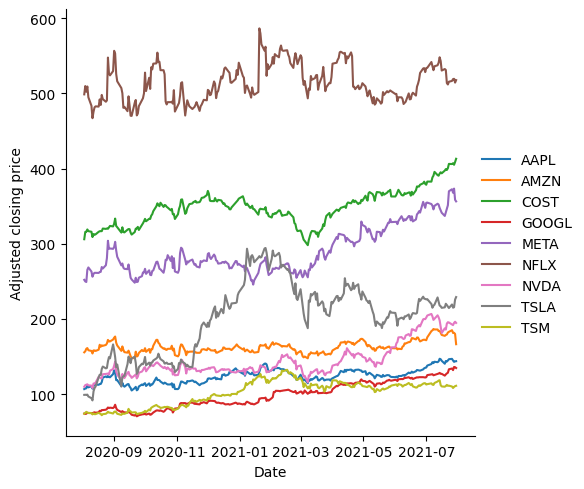

In [5]:
fig = sns.relplot(data=stock_levels_df['Adj Close'],dashes = False,
            kind="line") # , palette="coolwarm"
fig.set_axis_labels('Date','Adjusted closing price')

In [6]:
# normalize the initial stock price levels to 1
normalized_stock_levels = stock_levels_df['Adj Close']/stock_levels_df['Adj Close'].iloc[0]

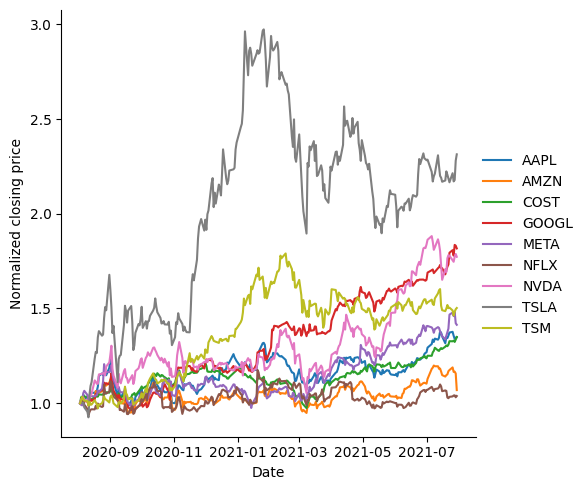

In [7]:
fig = sns.relplot(data=normalized_stock_levels,dashes = False,
            kind="line") # , palette="coolwarm"
fig.set_axis_labels('Date','Normalized closing price')

In [8]:
#%% daily log return

daily_log_r = stock_levels_df['Adj Close'].apply(lambda x: np.log(x) - np.log(x.shift(1)))

daily_log_r = daily_log_r.dropna()

#%% Variance-covariance matrix
# Compute the covariance matrix
cov_SIGMA = daily_log_r.cov()

Text(0.5, 1.0, 'Covariance matrix of historical data')

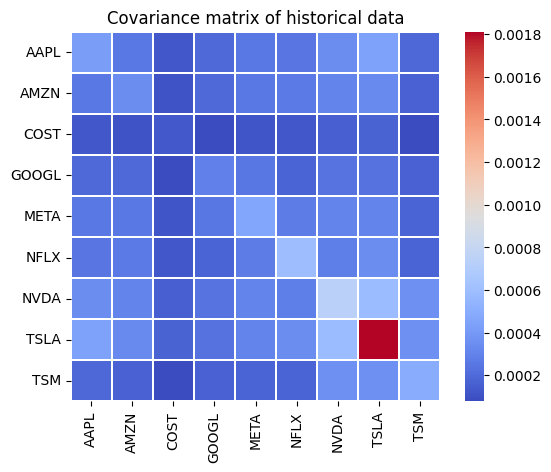

In [9]:
# Set up the matplotlib figure
fig, ax = plt.subplots()

sns.heatmap(cov_SIGMA, cmap="coolwarm",
            square=True, linewidths=.05)
plt.title('Covariance matrix of historical data')

#%% correlation matrix

In [10]:
# Compute the correlation matrix
corr_P = daily_log_r.corr()

Text(0.5, 1.0, 'Correlation matrix of historical data')

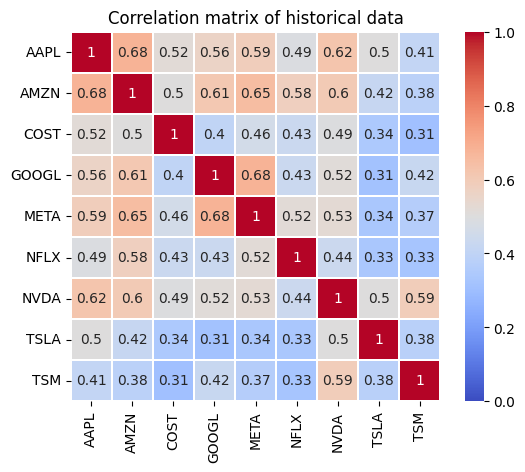

In [11]:
# Set up the matplotlib figure
fig, ax = plt.subplots()

sns.heatmap(corr_P, cmap="coolwarm",
            square=True, linewidths=.05, annot=True,
            vmax = 1,vmin = 0)
plt.title('Correlation matrix of historical data')

In [12]:
# 椭圆

In [13]:
#%% Cholesky decomposition

import scipy.linalg


L = scipy.linalg.cholesky(cov_SIGMA, lower=True)
R = scipy.linalg.cholesky(cov_SIGMA, lower=False)

Text(0.5, 1.0, 'R')

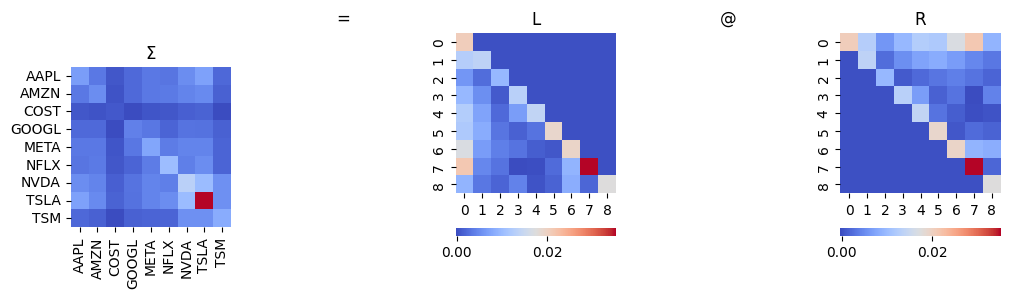

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3))

plt.sca(axs[0])
ax = sns.heatmap(cov_SIGMA,cmap='coolwarm', cbar=False)
ax.set_aspect("equal")
plt.title('$\Sigma$')

plt.sca(axs[1])
plt.title('=')
plt.axis('off')

plt.sca(axs[2])
ax = sns.heatmap(L,cmap='coolwarm',
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('L')

plt.sca(axs[3])
plt.title('@')
plt.axis('off')

plt.sca(axs[4])
ax = sns.heatmap(R,cmap='coolwarm',
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")
plt.title('R')

In [15]:
#%% Correlated stock price simulation

# convert daily parameters to yearly
mu_yearly = daily_log_r.mean()*250
R_yearly  = R*np.sqrt(250)
SIGMA_yearly = cov_SIGMA*250

n = 250
# simulation steps

dt = 1/250 
# assume 250 business days in a year

S0 = stock_levels_df['Adj Close'].iloc[-1]

S0 = np.array(S0)
# current stock price levels

Z = np.random.normal(0, 1, size=(n, 9))
# only simulate one set of paths

drift = (mu_yearly - np.diag(SIGMA_yearly)/2)*dt;
drift = np.array(drift)

vol  = Z@R_yearly*np.sqrt(dt);

S = np.exp(drift + vol)

S = np.vstack([np.ones(9), S])
# add a layer of ones

S = S0 * S.cumprod(axis=0)
# compute the stock levels

Sim_df = pd.DataFrame(data=S, columns=tickers)
# convert the result to a dataframe

Text(0.5, 1.0, 'Simulated levels, one set of paths')

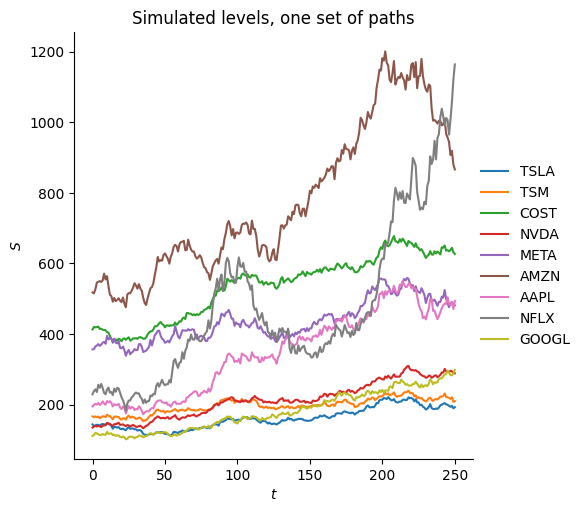

In [16]:
fig = sns.relplot(data=Sim_df,dashes = False,
            kind="line") # , palette="coolwarm"

plt.xlabel("$t$")
plt.ylabel("$S$")
plt.title('Simulated levels, one set of paths')

In [17]:
#%% Compute the correlation matrix of the simulated results

daily_log_sim = Sim_df.apply(lambda x: np.log(x) - np.log(x.shift(1)))
daily_log_sim = daily_log_sim.dropna()


# Compute the correlation matrix
corr_P_sim = daily_log_sim.corr()

Text(0.5, 1.0, 'Correlation matrix of simulated results')

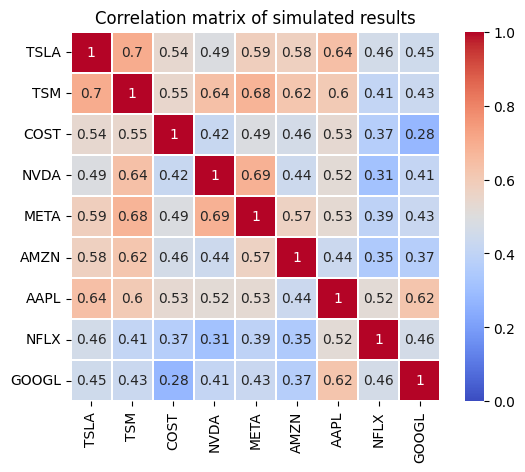

In [18]:
# Set up the matplotlib figure
fig, ax = plt.subplots()

sns.heatmap(corr_P_sim, cmap="coolwarm",
            square=True, linewidths=.05, annot=True,
            vmax = 1,vmin = 0)

plt.title('Correlation matrix of simulated results')

Text(0.5, 1.0, 'Differences, correlation matrix')

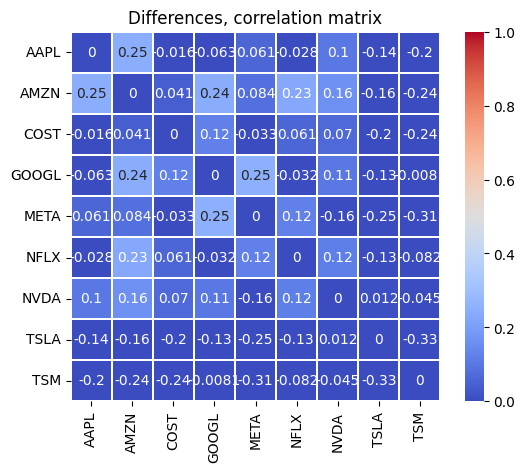

In [19]:
# calculate the differences between historical and simulated
fig, ax = plt.subplots()

sns.heatmap(corr_P - corr_P_sim, cmap="coolwarm",
            square=True, linewidths=.05, annot=True,
            vmax = 1,vmin = 0)

plt.title('Differences, correlation matrix')